## seq2seq practice
### Generating names with recurrent neural networks

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Our data
The dataset contains ~8k earthling names from different cultures, all in latin transcript.

This notebook has been designed so as to allow you to quickly swap names for something similar: deep learning article titles, IKEA furniture, pokemon names, etc.

In [1]:
# Uncomment this cell in Colab

# ! wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/week0_10_embeddings_and_seq2seq/names -O names

In [ ]:
import os
start_token = " "

with open("names") as f:
    names = f.read()[:-1].split('\n')
    names = [start_token + line.lower() for line in names]

In [ ]:
print ('n samples = ',len(names))
for x in names[::1000]:
    print (x)

n samples =  7944
 abagael
 claresta
 glory
 liliane
 prissie
 geeta
 giovanne
 piggy


max length = 16


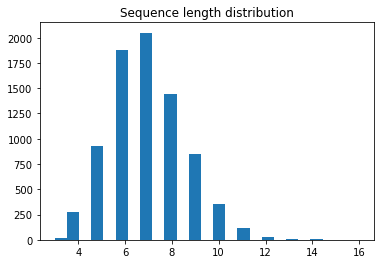

In [ ]:
MAX_LENGTH = max(map(len, names))
print("max length =", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, names)),bins=25);

# Text processing

First we need next to collect a "vocabulary" of all unique tokens i.e. unique characters. We can then encode inputs as a sequence of character ids.

In [ ]:
for name in names:
  if " " in name[1:]:
    print(name[1:])

dee dee
jo ann
zsa zsa


In [ ]:
#all unique characters go here
tokens = set("".join(names).lower())

tokens = list(tokens)

num_tokens = len(tokens)
print ('num_tokens = ', num_tokens)

assert 25 < num_tokens < 30, "Names should contain within 25 and 30 unique tokens depending on encoding"

num_tokens =  29


### Convert characters to integers

To train our neural network, we'll need to replace characters with their indices in tokens list.

Let's compose a dictionary that does this mapping.

In [ ]:
token_to_id = <dictionary of symbol -> its identifier (index in tokens list)>

In [2]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

In [ ]:
def to_matrix(names, max_len=None, pad=token_to_id[' '], dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        line_ix = [token_to_id[c] for c in names[i]]
        names_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        names_ix = np.transpose(names_ix)

    return names_ix

In [1]:
#Example: cast 4 random names to matrices, pad with zeros
print('\n'.join(names[::2000]))
print(to_matrix(names[::2000]))

### Create Dataset


In [ ]:
import tensorflow as tf


In [ ]:
MAX_LENGTH = 16

vectorized_names = #YOUR CODE HERE
dataset = tf.data.Dataset.from_tensor_slices(vectorized_names)

In [ ]:
def split_input_target(sequence):
    #YOUR CODE HERE
    return input_text, target_text

dataset = dataset.map(split_input_target)

In [3]:
sample_x, sample_y = next(iter(dataset))

sample_x, sample_y

In [ ]:
BATCH_SIZE = 64

dataset = (
    dataset
    .shuffle(1024)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

# Recurrent neural network

We can rewrite recurrent neural network as a consecutive application of dense layer to input $x_t$ and previous rnn state $h_t$. This is exactly what we're gonna do now.

Since we're training a language model, there should also be:
* An embedding layer that converts character id x_t to a vector.
* An output layer that predicts probabilities of next phoneme

In [ ]:
class RNNModel(tf.keras.Model):
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=128):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = tf.keras.layers.Embedding(num_tokens, embedding_size)
        self.rnn_update = tf.keras.layers.Dense(rnn_num_units)
        self.rnn_to_logits = tf.keras.layers.Dense(num_tokens)
    
    def rnn_cell(self, x_current_emb, h_prev, training=False):
        # compute next hidden state using self.rnn_update
        # hint: use tf.concat(..., axis=...) for concatenation
        x_and_h = #YOUR CODE HERE
        h_next = #YOUR CODE HERE
        
        h_next = #YOUR CODE HERE
        
        assert h_next.shape == h_prev.shape

        #compute logits for next character probs
        logits =  #YOUR CODE

        return h_next, tf.nn.log_softmax(logits, axis=-1)
        
    def call(self, inputs, states=None, return_state=False, training=False):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        x = inputs
        # get vector embedding of x
        x_emb = #YOUR CODE
        
        if states is None:
            h_prev = self.initial_state(x.shape[0])
        else:
            h_prev = states
        
        logprobs = tf.TensorArray(tf.float32, size=x.shape[1])
        states = tf.TensorArray(tf.float32, size=x.shape[1])

        x_emb_transposed = tf.transpose(x_emb, perm=[1, 0, 2])

        for idx in tf.range(x.shape[1]):
            # use here your one-step code
            h_prev, logp_next = self.rnn_cell(
                x_emb_transposed[idx], h_prev, training=training)  
            logprobs = logprobs.write(idx, logp_next)
            states = states.write(idx, h_prev)

        if return_state:
            return tf.transpose(states.stack(), [1, 0, 2]), tf.transpose(logprobs.stack(), [1, 0, 2])
        else:
            return tf.transpose(logprobs.stack(), [1, 0, 2])
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return tf.zeros((batch_size, self.num_units))

In [ ]:
model = RNNModel()

In [4]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

### The training loop

We train our char-rnn exactly the same way we train any deep learning model: by minibatch sgd.

The only difference is that this time we sample strings, not images or sound.

In [ ]:

model.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True))

In [5]:
# EPOCHS = 500
EPOCHS = 100

history = model.fit(
    dataset, epochs=EPOCHS, 
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(filepath="best_model.h5", save_best_only=True), 
        tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-4, patience=5)
    ]
)


In [6]:
loss_history = history.history['loss']
epochs_range = range(len(loss_history))

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, loss_history)
plt.title('Training loss')

plt.show()

### RNN: sampling
Once we've trained our network a bit, let's get to actually generating stuff. 
All we need is the single rnn step function you have defined in `char_rnn.forward`.

In [ ]:
class OneStep(tf.keras.Model):
  def __init__(self, model, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model

  @tf.function
  def generate_one_step(self, inputs, states=None):  
    # Run the model, get states and predictions
    states, predicted_logits = #YOUR CODE

    # Only use the last prediction.
    predicted_logits_last_step = #YOUR CODE
    predicted_logits_last_step = predicted_logits_last_step / self.temperature
    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    
    # get the last model state
    state = #YOUR CODE
    
    return state, predicted_ids


In [ ]:
one_step_model = OneStep(model)


In [7]:
seed_phrase = ' Sherl'.lower()
seed_phrase_tensor = [token_to_id[token] for token in seed_phrase]

seed_phrase_tensor

In [ ]:
next_char = tf.convert_to_tensor([seed_phrase_tensor])

result = [next_char]
last_state = None

for n in range(MAX_LENGTH - len(seed_phrase)):
  last_state, next_char = one_step_model.generate_one_step(next_char, states=last_state)
  result.append(next_char)



In [ ]:
idxes_result = np.concatenate([ix[0].numpy() for ix in result])

In [8]:
idxes_result

In [9]:
''.join([tokens[idx] for idx in idxes_result])


In [ ]:
def generate_sample(one_step_model, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    #YOUR CODE
    pass

In [10]:
for _ in range(10):
    print(generate_sample(one_step_model))

In [11]:
for _ in range(50):
    print(generate_sample(one_step_model, seed_phrase=' Sherl'.lower()))

### More seriously

What we just did is a manual low-level implementation of RNN. While it's cool, i guess you won't like the idea of re-writing it from scratch on every occasion. 

As you might have guessed, tf has a solution for this. 

### Try it out!
You've just implemented a recurrent language model that can be tasked with generating any kind of sequence, so there's plenty of data you can try it on:

* Novels/poems/songs of your favorite author
* News titles/clickbait titles
* Source code of Linux or Tensorflow
* Molecules in [smiles](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) format
* Melody in notes/chords format
* Ikea catalog titles
* Pokemon names
* Cards from Magic, the Gathering / Hearthstone

If you're willing to give it a try, here's what you wanna look at:
* Current data format is a sequence of lines, so a novel can be formatted as a list of sentences. Alternatively, you can change data preprocessing altogether.
* While some datasets are readily available, others can only be scraped from the web. Try `Selenium` or `Scrapy` for that.
* Make sure MAX_LENGTH is adjusted for longer datasets. There's also a bonus section about dynamic RNNs at the bottom.
* More complex tasks require larger RNN architecture, try more neurons or several layers. It would also require more training iterations.
* Long-term dependencies in music, novels or molecules are better handled with LSTM or GRU

__Good hunting!__